### UML Species Delimitation Notebook
R code = Alex Pyron; rpyron@colubroid.org; Notebook = Kyle O'Connell; kyleaoconnell22gmail.com

Here we introduce a novel approach to unguided species delimitation using self organizing maps (SOMs), a machine learning (ML) method also known as Kohonon maps. These SOMs reduce multi-dimentional data to a two dimentional configuration that maximizes the similarity between a distance matrix of input and output features. The result is to identify discrete genotype clusters composed of similar individuals. For a full expanation of the theory behind SOMs and an implementation of the method, see Pyron et al. (2022). 

The goal of this notebook is for you to explore this ML method and see if it would be a good fit for your own dataset. Try it out first with the example data from Pyron et al. (2022), then try it with your own structure file and see how it works with your own data. The default parameters are tuned to the example data, so when you use your own data make sure you modify the parameters and check model fit. 

### Install Dependencies
If running on Binder, these are all installed for you within the environment. However, if running locally, you will need to make sure they are all installed. The exception is adegenet, which does not install correctly in the Binder setup, so you will need to run the block below to install the dev version.

If running locally...

In [22]:
install.packages(c('adegenet','maps','viridis','kohonen'))

Installing packages into ‘/srv/rlibs’
(as ‘lib’ is unspecified)

also installing the dependency ‘viridisLite’


Warning message in install.packages(c("adegenet", "maps", "viridis", "kohonen")):
“installation of package ‘adegenet’ had non-zero exit status”
Warning message in install.packages(c("adegenet", "maps", "viridis", "kohonen")):
“installation of package ‘maps’ had non-zero exit status”
Warning message in install.packages(c("adegenet", "maps", "viridis", "kohonen")):
“installation of package ‘kohonen’ had non-zero exit status”


If running on Binder...

In [ ]:
options(
  repos = c(
    zkamvar = "https://zkamvar.r-universe.dev",
    CRAN = "https://cloud.r-project.org"
  )
)
install.packages("adegenet")

Installing package into ‘/srv/rlibs’
(as ‘lib’ is unspecified)



In [2]:
#load dependencies
library(adegenet); library(maps); library(viridis); library(kohonen)
set.seed(1)

Loading required package: ade4

Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar

Warning message:
“replacing previous import ‘vctrs::data_frame’ by ‘tibble::data_frame’ when loading ‘dplyr’”

   /// adegenet 2.1.5 is loaded ////////////

   > overview: '?adegenet'
   > tutorials/doc/questions: 'adegenetWeb()' 
   > bug reports/feature requests: adegenetIssues()



Loading required package: viridisLite


Attaching package: ‘viridis’


The following object is masked from ‘package:maps’:

    unemp



Attaching package: ‘kohonen’


The following object is masked from ‘package:maps’:

    map




### Read in the data
Here we will read in the structure format data using adegenet. The data has 71 individuals, 7809 loci. If alleles are separated by column, then onrowperind = false, if they are split by line, then make that true. For the SOM method, do no include the population column (col 2), and then make sure to set col.pop = 0. Read more on the [adegenet manual](https://rdrr.io/cran/adegenet/man/read.structure.html).

In [3]:
#Read in STRUCTURE file from ipyrad
a <- read.structure("./seal_in.str",
                    n.ind = 71,
                    n.loc = 7809,
                    onerowperind = FALSE,
                    col.lab = 1,
                    col.pop = 0,
                    col.others = 0,
                    row.marknames = 0,
                    NA.char = -9)


 Converting data from a STRUCTURE .stru file to a genind object... 



In [4]:
# Let's take a quick look
a

/// GENIND OBJECT /////////

 // 71 individuals; 7,809 loci; 15,948 alleles; size: 8.3 Mb

 // Basic content
   @tab:  71 x 15948 matrix of allele counts
   @loc.n.all: number of alleles per locus (range: 2-4)
   @loc.fac: locus factor for the 15948 columns of @tab
   @all.names: list of allele names for each locus
   @ploidy: ploidy of each individual  (range: 2-2)
   @type:  codom
   @call: read.structure(file = "./seal_in.str", n.ind = 71, n.loc = 7809, 
    onerowperind = FALSE, col.lab = 1, col.pop = 0, col.others = 0, 
    row.marknames = 0, NA.char = -9)

 // Optional content
   @other: a list containing: X 


Read in the locality information for naming populations and mapping. The input file needed should be a csv that has at minimum the following columns: 
Specimen, mtClade (a priori sp assignment from mtDNA or clustering like Admixture), Lat, Long, State, and County

In [5]:
# Read in the locality data
dat <- read.csv("./gbs_73_localities.csv")
pops <- factor(dat$mtClade[match(row.names(a$tab),dat$Specimen)])
a$pop <- pops
xy <- dat[,9:8][match(row.names(a$tab),dat$Specimen),]; rownames(xy) <- dat$Specimen[match(row.names(a$tab),dat$Specimen)]
a@other$xy <- xy
a.orig <- a

In [6]:
# Take a look at the locality data to replicate with your own csv file
head(dat)

,Sample,Specimen,Species,mtClade,Locality,State,County,Lat,Long,Notes
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>
1,RAP1141,RAP1141_monticola_A,cheaha,monticola_A,Ivy Creek (RE Bob Woodruff Park),AL,Autauga,32.39819,-86.79017,
2,RAP1016,RAP1016_monticola_A,cheaha,monticola_A,Bolen Town Rd.,AL,Clarke,31.58505,-87.96500,
3,RAP1136,RAP1136_monticola_A,cheaha,monticola_A,Limestone Creek (Fred T. Stimpson SOA),AL,Clarke,31.39853,-87.85067,
4,RAP0707,RAP0707_monticola_A,cheaha,monticola_A,Forever Wild - Red Hills Complex,AL,Monroe,31.73246,-87.36745,
5,RAP1030,RAP1030_monticola_A,cheaha,monticola_A,"Haines Island, Davis Ferry",AL,Monroe,31.72071,-87.46518,
6,RAP1134,RAP1134_monticola_A,cheaha,monticola_A,Red Hills Complex (Forever Wild),AL,Monroe,31.73183,-87.36729,


In [7]:
# Convert to a genind object of allele frequencies
struc <- makefreq(a)


 Finding allelic frequencies from a genpop object... 

...done.



In [8]:
# Take a look at the allele frequencies
head(struc)

,L0001.02,L0001.00,L0002.03,L0002.01,L0003.02,L0003.00,L0004.03,L0004.01,L0005.00,L0005.02,⋯,L7805.00,L7806.03,L7806.01,L7807.00,L7807.02,L7807.01,L7808.01,L7808.02,L7809.00,L7809.02
RAP0634_monticola_B,1.0,0.0,1.0,0.0,NA,NA,1,0,NA,NA,⋯,NA,1,0,1,0,0,1,0,1,0
RAP0641_monticola_B,1.0,0.0,1.0,0.0,1,0,1,0,1,0,⋯,NA,1,0,1,0,0,1,0,1,0
RAP0656_monticola_A,0.5,0.5,0.5,0.5,1,0,1,0,1,0,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
RAP0673_monticola_B,1.0,0.0,1.0,0.0,1,0,1,0,1,0,⋯,0,1,0,1,0,0,1,0,1,0
RAP0679_monticola_A,1.0,0.0,1.0,0.0,1,0,1,0,1,0,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
RAP0686_monticola_B,1.0,0.0,1.0,0.0,1,0,1,0,1,0,⋯,0,1,0,NA,NA,NA,1,0,1,0


In [9]:
# Convert the allele frequencies to a matrix
struc_matrix <- matrix(unlist(as.numeric(struc)), nrow=nrow(struc))
head(struc_matrix)

1.0,0.0,1.0,0.0,NA,NA,1,0,NA,NA,⋯,NA,1,0,1,0,0,1,0,1,0
1.0,0.0,1.0,0.0,1,0,1,0,1,0,⋯,NA,1,0,1,0,0,1,0,1,0
0.5,0.5,0.5,0.5,1,0,1,0,1,0,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1.0,0.0,1.0,0.0,1,0,1,0,1,0,⋯,0,1,0,1,0,0,1,0,1,0
1.0,0.0,1.0,0.0,1,0,1,0,1,0,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1.0,0.0,1.0,0.0,1,0,1,0,1,0,⋯,0,1,0,NA,NA,NA,1,0,1,0


In [10]:
# Convert the data to a grid
size <- round(sqrt(dim(struc)[1]))#round(5 * sqrt(dim(struc_matrix)[1]))
som_grid <- somgrid(xdim = size, ydim=size, topo="hexagonal")
head(som_grid)

x,y
1.5,0.8660254
2.5,0.8660254
3.5,0.8660254
4.5,0.8660254
5.5,0.8660254
6.5,0.8660254
7.5,0.8660254
8.5,0.8660254
1.0,1.7320508
2.0,1.7320508


### Train the model
Now we have all the input data ready and we can train the model. The input is the data matrix, the grid, and a few parameters. The model doesn't take long to train, so it is a good idea to experiment with the parameter values for your dataset. 'rlen' = number of generations, 'alpha' = learning rate. As we said above, these parameters are set for the example data, make sure you experiment with your data. For more info on the som model, read [here](https://www.rdocumentation.org/packages/kohonen/versions/2.0.19/topics/som). *if running on Binder, you only have 2 threads, so you may want to reduce rlen to 100 when just exploring the notebook. Otherwise it can take several minutes.

In [13]:
# Train the model
som_model <- som(struc_matrix,
                 grid=som_grid,
                 rlen=100,
                 alpha=c(0.05,0.01),
                 keep.data = TRUE,
                 maxNA.fraction=0.5)

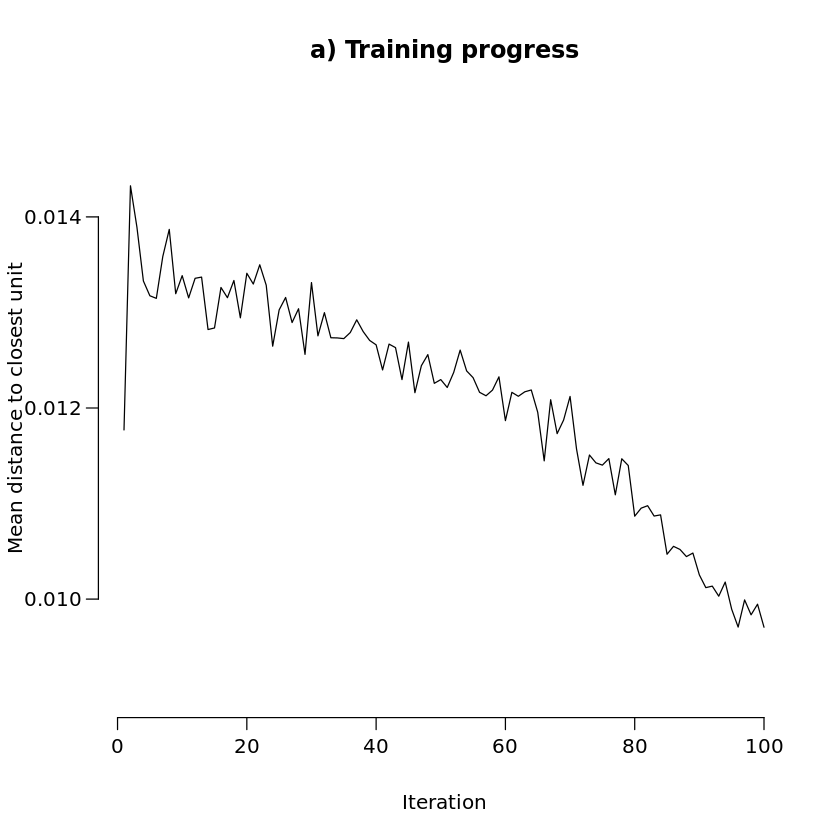

In [14]:
# Here we plot the model, and you want to find the value where the distance plateaus.
par(mgp=c(3,0.67,0))
plot(som_model, type="changes", main = "a) Training progress", axes=F, ylim=c(0.009,0.015))
axis(1);axis(2,at=c(0.01,0.012,0.014),las=2)

### Identify the right number of clusters

Now we want to use k means clustering to choose the 'best' number of clusters. 

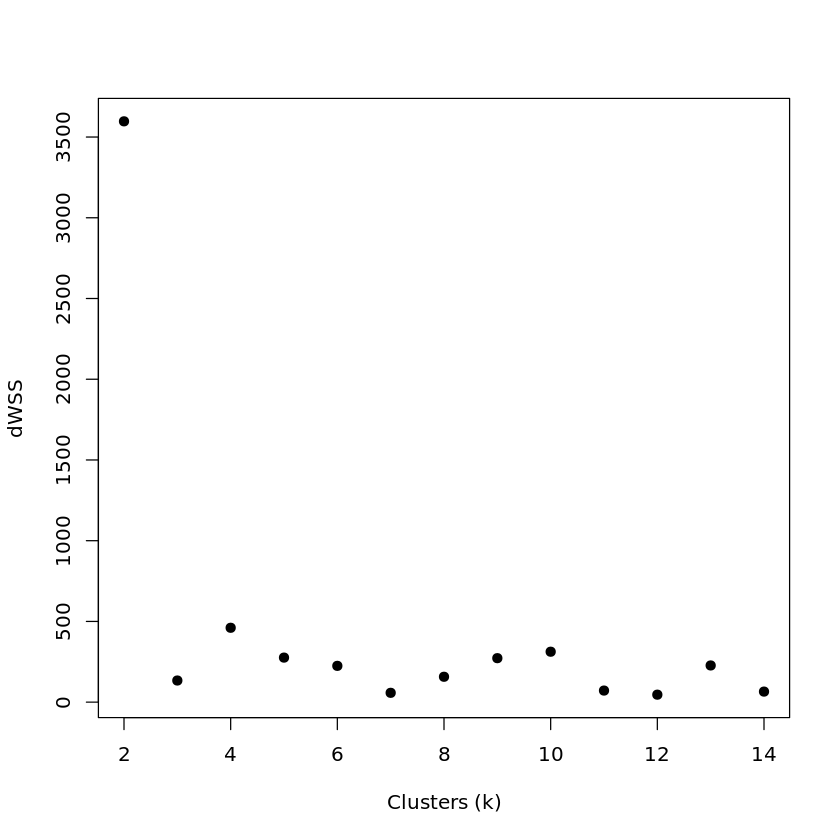

In [15]:
mydata <- getCodes(som_model)
wss <- (nrow(mydata)-1)*sum(apply(mydata,2,var)) 
for (i in 1:15) {
  wss[i] <- sum(kmeans(mydata, centers=i)$withinss)
}
d_wss <- abs(diff(diff(wss)))
plot(2:14,d_wss, xlab="Clusters (k)",pch=19,ylab="dWSS")
num_clusters <- (2:14)[which(d_wss==max(d_wss))]

### Cluster the inividuals

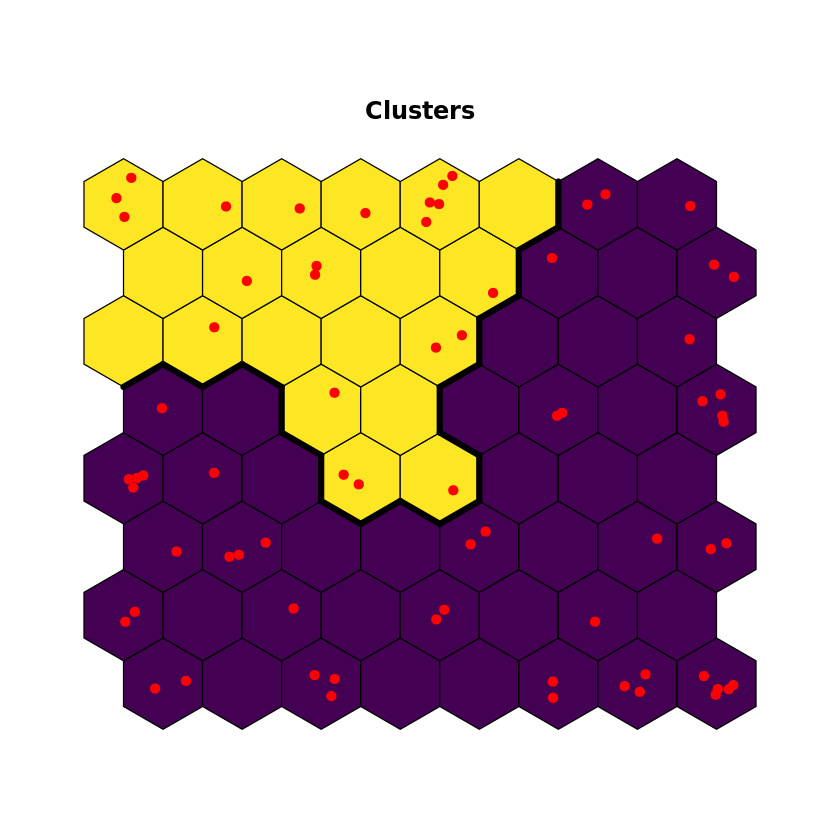

In [16]:
## use hierarchical clustering to cluster the codebook vectors
som_cluster <- cutree(hclust(dist(mydata)), num_clusters)
# plot these results:
plot(som_model, shape="straight", type="mapping", bgcol = viridis(num_clusters)[som_cluster], main = "Clusters", 
     pch=19, col="red")#, labels=paste(clade.data$DAB,clade.data$nClade,sep=" "), cex=0.5) 
add.cluster.boundaries(som_model, som_cluster)

In [17]:
# get vector with cluster value for each original data sample
cluster_assignment <- som_cluster[som_model$unit.classif]
# for each of analysis, add the assignment as a column in the original data:
# data$cluster <- cluster_assignment
cbind(rownames(a$tab),cluster_assignment)
dev.off()

,,cluster_assignment
V3,RAP0634_monticola_B,1
V13,RAP0641_monticola_B,1
V56,RAP0656_monticola_A,1
V40,RAP0673_monticola_B,1
V63,RAP0679_monticola_A,1
V40,RAP0686_monticola_B,1
V45,RAP0707_monticola_A,2
V33,RAP0713_monticola_B,1
V21,RAP0719_monticola_B,1
V18,RAP0731_monticola_B,1


null device 
          1

### Map the clusters

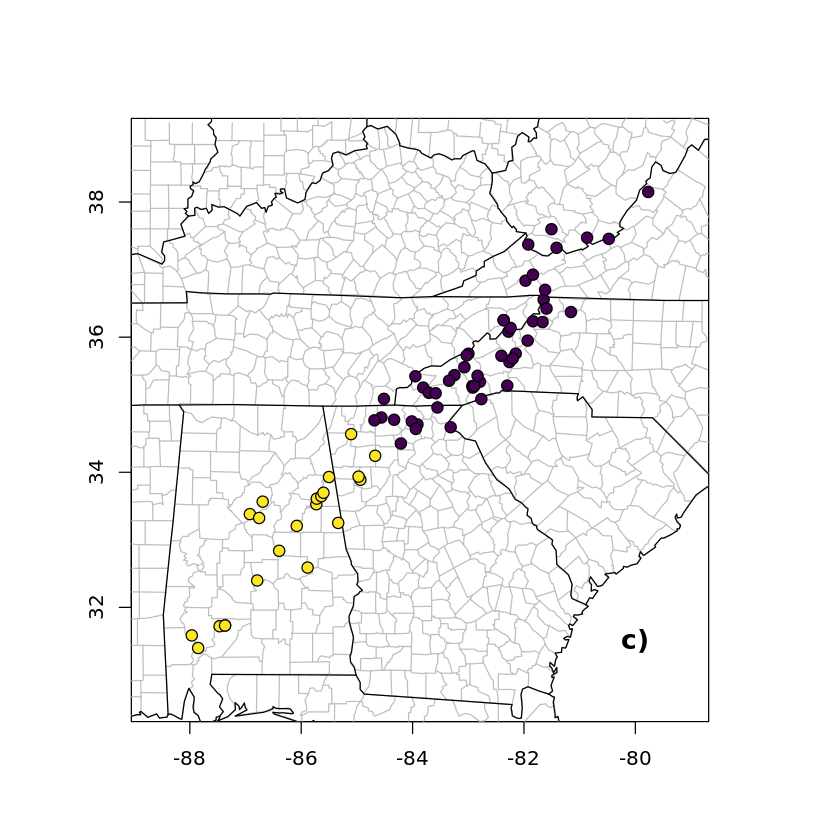

In [18]:
maps::map(database = 'county', xlim = range(xy[,1]) + c(-1,1), ylim = range(xy[,2]) + c(-1,1), col="white")
text(-80,31.5,"c)",cex=1.33,font=2);map.axes()
maps::map(database = 'county', xlim = range(xy[,1]) + c(-1,1), ylim = range(xy[,2]) + c(-1,1), col="gray",add=T)
maps::map(database = 'state', xlim = range(xy[,1]) + c(-1,1), ylim = range(xy[,2]) + c(-1,1), add = T)
#map.scale(x=-81,y=31,relwidth=0.1,ratio=FALSE,cex=0.67)
#legend(x=-82.5,y=33.5,legend=c("monticola B","monticola A/C"),viridis(2))
points(xy[rownames(a$tab),], bg=viridis(2)[cluster_assignment], pch=21, cex=1.25)

### Plot the SOM nodes
In the next figure, the nodes with individuals are colored, whereas the nodes without are gray. Thus, nodes with multiple individuals represent clusters of very similar inidividuals. The color of the node tells you how many individuals are clustered within.

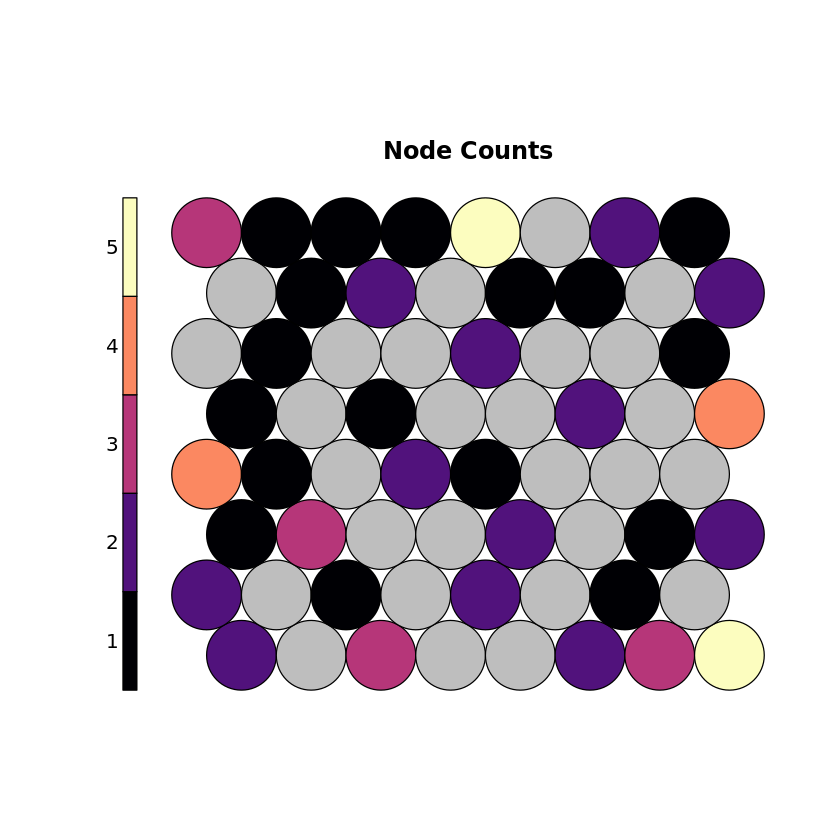

In [19]:
#Plot the note counts
plot(som_model, type="count", main="Node Counts", palette.name = magma)

Here, we are plotting the distance between cells. We expect the distances to cluster similar to the individual clusters

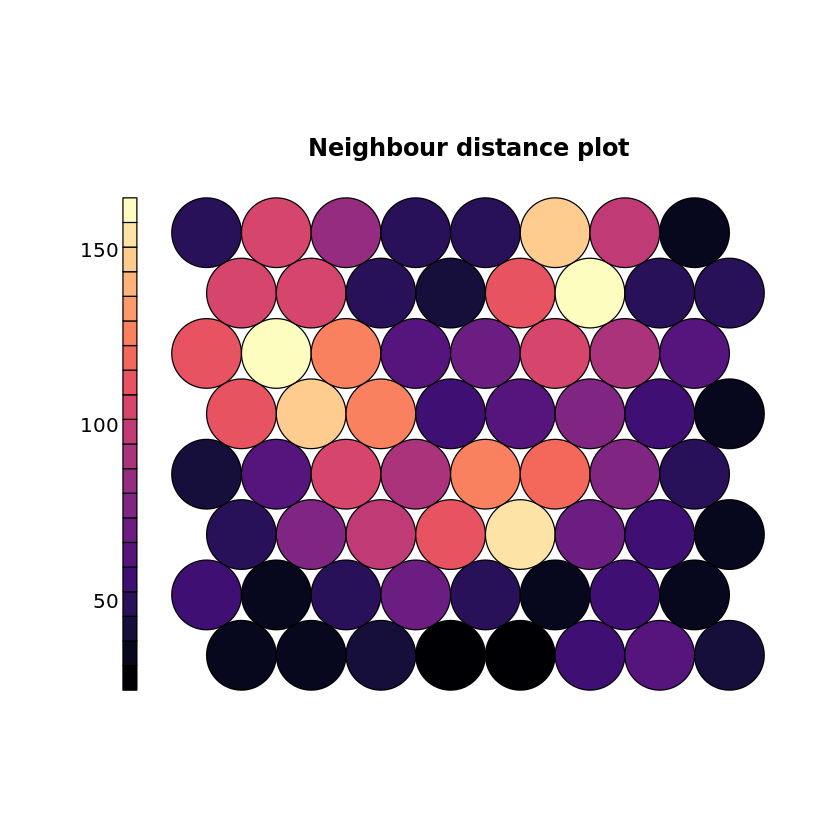

In [21]:
# Plot the Cell distances
plot(som_model, type="dist.neighbours", "SOM neighbour distances", palette.name = magma)

And that is it! Once you run through the example data, play with your own data and see how the learning rate and number of generations affect your results.